In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import warnings
warnings.filterwarnings("ignore")

In [30]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

train_df = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
test_df = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

print('Dimensions of the Training set:',train_df.shape)
print('Dimensions of the Test set:',test_df.shape)


Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [31]:
def process_labels(df):
    df['label'] = df['label'].str.strip().str.lower()
    df['label'] = df['label'].apply(
        lambda x: 'Benign' if x == 'normal' else 'Malicious'
    )
    return df

train_df = process_labels(train_df)
test_df  = process_labels(test_df)


In [32]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']


In [33]:
categorical_cols = ['protocol_type', 'service', 'flag']

encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier( random_state=42, class_weight="balanced", n_jobs=-1 ) 
param_grid = { 'n_estimators': [100, 200, 300], 
              'max_depth': [10, 20, None], 
              'min_samples_split': [2, 10, 50], 
              'min_samples_leaf': [1, 5, 10] }

random_search = RandomizedSearchCV(
    rf,
    
    param_distributions=param_grid,
    n_iter=20,         
    scoring='recall',
    cv=3,              
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

print("Best Parameters:")
print(random_search.best_params_) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\hp\venv\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best Parameters:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}


In [35]:
best_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_prob = best_rf.predict_proba(X_test)[:, 1]


In [38]:
threshold = 0.25   # try 0.25–0.40
y_pred_custom = np.where(y_prob >= threshold, 'Malicious', 'Benign')


              precision    recall  f1-score   support

      Benign       0.74      0.96      0.84      9711
   Malicious       0.97      0.75      0.84     12833

    accuracy                           0.84     22544
   macro avg       0.86      0.86      0.84     22544
weighted avg       0.87      0.84      0.84     22544



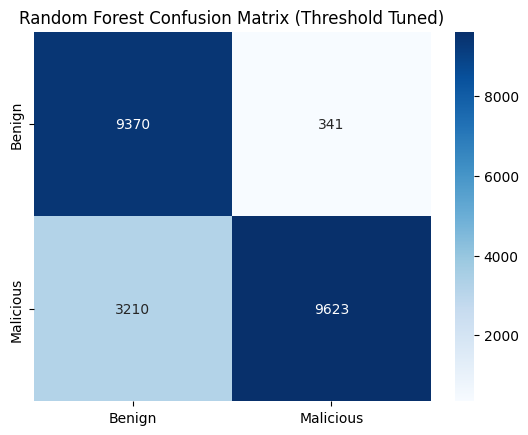

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

cm_new = confusion_matrix(y_test, y_pred_custom)

print(classification_report(y_test, y_pred_custom))

sns.heatmap(
    cm_new,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Benign', 'Malicious'],
    yticklabels=['Benign', 'Malicious']
)

plt.title("Random Forest Confusion Matrix (Threshold Tuned)")
plt.show()


In [51]:
print("Accuracy :", accuracy_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom, pos_label='Malicious'))
print("Recall   :", recall_score(y_test, y_pred_custom, pos_label='Malicious'))
print("F1 Score :", f1_score(y_test, y_pred_custom, pos_label='Malicious'))


Accuracy : 0.8424858055358411
Precision: 0.9657767964672822
Recall   : 0.7498636328216317
F1 Score : 0.8442338904241786


In [46]:
importances = best_rf.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp.head(10))


                        Feature  Importance
4                     src_bytes    0.202810
5                     dst_bytes    0.101823
28                same_srv_rate    0.078424
33       dst_host_same_srv_rate    0.070259
32           dst_host_srv_count    0.065494
3                          flag    0.063819
11                    logged_in    0.051818
1                 protocol_type    0.037754
29                diff_srv_rate    0.034553
35  dst_host_same_src_port_rate    0.032198


In [47]:
best_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
import pickle

# Final threshold used
FINAL_THRESHOLD = 0.25   # or 0.35 (use the one you selected)

# Save Random Forest model
with open("random_forest_ids.pkl", "wb") as f:
    pickle.dump(best_rf, f)

# Save encoder
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Save threshold
with open("threshold.pkl", "wb") as f:
    pickle.dump(FINAL_THRESHOLD, f)

print("Model, encoder, and threshold saved successfully!")


Model, encoder, and threshold saved successfully!


In [49]:
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(list(X_train.columns), f)

print("Feature columns saved!")


Feature columns saved!


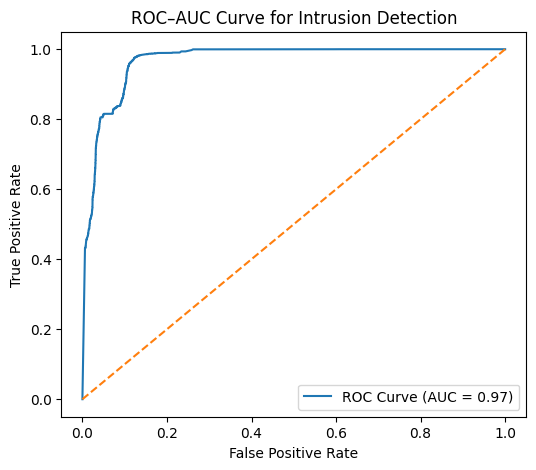

In [56]:
from sklearn.metrics import roc_curve, auc

# Probability predictions
y_prob = best_rf.predict_proba(X_test)

malicious_index = list(best_rf.classes_).index("Malicious")
y_scores = y_prob[:, malicious_index]

# ROC calculation
fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label="Malicious")
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve for Intrusion Detection")
plt.legend()
plt.show()
